In [ ]:
#!pip install -q git+https://github.com/sebastian-sz/efficientnet-v2-keras@main

In [1]:
import os
import tensorflow as tf
from efficientnet_v2 import *
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
from tensorflow.keras import callbacks
import pandas as pd
from keras.utils import generic_utils
from efficientnet_v2 import get_preprocessing_layer
from keras import layers
from keras import models

2022-11-28 10:23:51.838258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 10:23:51.940058: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 10:23:51.964333: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 10:23:52.384809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Check Tensorflow  with GPU 

In [4]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [5]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
is_gpu = len(tf.config.experimental.list_physical_devices('GPU')) > 0
is_gpu

True

In [7]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
is_gpu

True

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()  

2022-11-28 10:24:09.924512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 10:24:10.363023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


'/device:GPU:0'

In [9]:
import tensorflow as tf
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [10]:
import tensorflow as tf

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-11-28 10:24:14.232020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


True

In [11]:
tf.test.gpu_device_name()

2022-11-28 10:24:15.126723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


'/device:GPU:0'

In [12]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2022-11-28 10:24:15.433509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-11-28 10:24:15.435468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


# dataset

In [23]:
dataframe = pd.read_csv('/home/yupaporn/codes/USAI/Traindf_fold1_2_viewingAngle.csv')  #Traindf_fold1_2_viewingAngle.csv
#dataframe = dataframe[dataframe['Sub_Position_New'] != 'None']
print(dataframe.shape)
dataframe.head()

(7047, 26)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,...,top,width,height,Rleft,Rtop,Rwidth,Rheight,filename,FileName,Sub_Position_Label
0,0,0,0,1,42,P1,P1,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,134.0,544.0,380.0,0.229956,0.149621,0.541516,0.422222,AB02 P1 C042.JPG,AB02 P1 C042.JPG,P1
1,1,1,1,2,42,P2,P2,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,140.0,497.0,549.0,0.237177,0.155682,0.494585,0.610101,AB02 P2 C042.JPG,AB02 P2 C042.JPG,P2
2,2,2,2,6,42,P1,P1,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,98.0,645.0,550.0,0.228564,0.109217,0.643761,0.612121,AB04 P1 C042.JPG,AB04 P1 C042.JPG,P1
3,3,3,3,7,42,P2,P2,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,123.0,516.0,547.0,0.203649,0.137500,0.519196,0.608081,AB04 P2 C042.JPG,AB04 P2 C042.JPG,P2
4,4,4,4,9,42,P2,P2,Abnormal,AB06,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,98.0,446.0,434.0,0.284593,0.109217,0.456401,0.482828,AB06 P2 C042.JPG,AB06 P2 C042.JPG,P2


In [24]:
len(list(set(dataframe['Sub_Position_Label'])))

14

In [24]:
#(list(set(dataframe['Path Crop'])))

In [25]:
#validation
valframe = pd.read_csv('/home/yupaporn/codes/USAI/Validationdf_fold1_2_viewingAngle.csv') #เปลี่ยนตาม fold
#valframe = valframe[valframe['Sub_Position_New'] != 'None']
print(valframe.shape)
valframe.head()

(975, 24)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,Path Crop,...,left,top,width,height,Rleft,Rtop,Rwidth,Rheight,filename,Sub_Position_Label
0,0,0,1,15,P1,P1,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,141.0,96.0,586.0,614.0,0.143898,0.107041,0.595628,0.683267,AB01 P1 C015.JPG,P1
1,1,1,2,15,P2,P2,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,242.0,101.0,491.0,451.0,0.245009,0.113017,0.497278,0.501992,AB01 P2 C015.JPG,P2
2,2,2,10,15,P2,P2,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,242.0,101.0,502.0,516.0,0.246118,0.113258,0.511070,0.573737,AB02 P2 C015.JPG,P2
3,3,3,11,15,P1,P1,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,257.0,103.0,538.0,634.0,0.256617,0.115278,0.537205,0.705051,AB02 P1 C015.JPG,P1
4,4,4,14,15,P2,P2,Abnormal,AB03,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,45.0,187.0,601.0,654.0,0.050314,0.196086,0.668817,0.682828,AB03 P2 C015.JPG,P2


In [26]:
DATA_PATH = "/media/tohn/SSD/Images/Image1"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/media/tohn/SSD/Images/Image1/train
/media/tohn/SSD/Images/Image1/validation


In [27]:
#Train
BATCH_SIZE = 32
TARGET_SIZE = (480, 480)  # M variant expects images in shape (480, 480)
epochs = 4

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'filename',
        y_col = 'Sub_Position_Label',
        target_size = TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = validation_dir,
        x_col = 'filename',
        y_col = 'Sub_Position_Label',
        target_size = TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        class_mode='categorical')

Found 7047 validated image filenames belonging to 14 classes.
Found 975 validated image filenames belonging to 14 classes.


In [30]:
train_generator

In [59]:
# for image_batch, label_batch in train_generator :
#     print(image_batch)
#     print(label_batch)

## Train (extract features)

Let us fine tune EfficientV2 M variant.

### Unfreeze  fully-connected/dense layer 

In [31]:
base_model = EfficientNetV2M(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
                include_top=False, weights="imagenet-21k")  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.

2022-11-28 10:25:24.543155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


In [32]:
base_model.output

<KerasTensor: shape=(None, 15, 15, 1280) dtype=float32 (created by layer 'top_activation')>

In [33]:
height = width = base_model.input_shape[1]
input_shape = (height, width, 3)
x = base_model.output 
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer_1 = layers.Dropout(0.2,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(12, activation='softmax',name = 'prediction_layer')(dropout_layer_1)

model = models.Model(inputs= base_model.input, outputs=prediction_layer) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 240, 240, 24  96          ['stem_conv[0][0]']              
                                )                                                             

 )                              )                                0]']                             
                                                                                                  
 block2-02_project_bn (BatchNor  (None, 120, 120, 48  192        ['block2-02_project_conv[0][0]'] 
 malization)                    )                                                                 
                                                                                                  
 block2-02_drop (Dropout)       (None, 120, 120, 48  0           ['block2-02_project_bn[0][0]']   
                                )                                                                 
                                                                                                  
 block2-02_add (Add)            (None, 120, 120, 48  0           ['block2-02_drop[0][0]',         
                                )                                 'block2-01_project_bn[0][0]']   
          

 )                                                               0]']                             
                                                                                                  
 block3-01_project_bn (BatchNor  (None, 60, 60, 80)  320         ['block3-01_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block3-02_expand_conv (Conv2D)  (None, 60, 60, 320)  230400     ['block3-01_project_bn[0][0]']   
                                                                                                  
 block3-02_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block3-02_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3-02

 block4-01_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block4-01_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block4-01_expand_activation (A  (None, 60, 60, 320)  0          ['block4-01_expand_bn[0][0]']    
 ctivation)                                                                                       
                                                                                                  
 block4-01_dwconv2 (DepthwiseCo  (None, 30, 30, 320)  2880       ['block4-01_expand_activation[0][
 nv2D)                                                           0]']                             
                                                                                                  
 block4-01_bn (BatchNormalizati  (None, 30, 30, 320)  1280       ['block4-01_dwconv2[0][0]']      
 on)      

                                                                                                  
 block4-03_bn (BatchNormalizati  (None, 30, 30, 640)  2560       ['block4-03_dwconv2[0][0]']      
 on)                                                                                              
                                                                                                  
 block4-03_activation (Activati  (None, 30, 30, 640)  0          ['block4-03_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-03_se_squeeze (GlobalAv  (None, 640)         0           ['block4-03_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-03

                                                                                                  
 block4-05_activation (Activati  (None, 30, 30, 640)  0          ['block4-05_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-05_se_squeeze (GlobalAv  (None, 640)         0           ['block4-05_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-05_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-05_se_squeeze[0][0]']   
                                                                                                  
 block4-05_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-05_se_reshape[0][0]']   
          

                                                                                                  
 block4-07_se_squeeze (GlobalAv  (None, 640)         0           ['block4-07_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-07_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-07_se_squeeze[0][0]']   
                                                                                                  
 block4-07_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-07_se_reshape[0][0]']   
                                                                                                  
 block4-07_se_expand (Conv2D)   (None, 1, 1, 640)    26240       ['block4-07_se_reduce[0][0]']    
                                                                                                  
 block4-07

                                                                                                  
 block5-02_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-02_se_reduce[0][0]']    
                                                                                                  
 block5-02_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-02_activation[0][0]',   
                                )                                 'block5-02_se_expand[0][0]']    
                                                                                                  
 block5-02_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-02_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-02_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-02_project_conv[0][0]'] 
 malizatio

 block5-04_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-04_se_reduce[0][0]']    
                                                                                                  
 block5-04_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-04_activation[0][0]',   
                                )                                 'block5-04_se_expand[0][0]']    
                                                                                                  
 block5-04_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-04_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-04_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-04_project_conv[0][0]'] 
 malization)                                                                                      
          

                                                                                                  
 block5-06_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-06_activation[0][0]',   
                                )                                 'block5-06_se_expand[0][0]']    
                                                                                                  
 block5-06_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-06_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-06_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-06_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-06

 block5-08_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-08_activation[0][0]',   
                                )                                 'block5-08_se_expand[0][0]']    
                                                                                                  
 block5-08_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-08_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-08_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-08_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-08_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-08_project_bn[0][0]']   
          

                                )                                 'block5-10_se_expand[0][0]']    
                                                                                                  
 block5-10_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-10_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-10_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-10_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-10_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-10_project_bn[0][0]']   
                                                                                                  
 block5-10

                                                                                                  
 block5-12_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-12_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-12_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-12_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-12_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-12_project_bn[0][0]']   
                                                                                                  
 block5-12_add (Add)            (None, 30, 30, 176)  0           ['block5-12_drop[0][0]',         
          

 block5-14_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-14_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-14_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-14_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-14_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-14_project_bn[0][0]']   
                                                                                                  
 block5-14_add (Add)            (None, 30, 30, 176)  0           ['block5-14_drop[0][0]',         
                                                                  'block5-13_add[0][0]']          
          

 block6-02_drop (Dropout)       (None, 15, 15, 304)  0           ['block6-02_project_bn[0][0]']   
                                                                                                  
 block6-02_add (Add)            (None, 15, 15, 304)  0           ['block6-02_drop[0][0]',         
                                                                  'block6-01_project_bn[0][0]']   
                                                                                                  
 block6-03_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-02_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-03_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-03_expand_conv[0][0]']  
 alization)                     )                                                                 
          

                                                                                                  
 block6-04_add (Add)            (None, 15, 15, 304)  0           ['block6-04_drop[0][0]',         
                                                                  'block6-03_add[0][0]']          
                                                                                                  
 block6-05_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-04_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-05_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-05_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-05

 block6-06_add (Add)            (None, 15, 15, 304)  0           ['block6-06_drop[0][0]',         
                                                                  'block6-05_add[0][0]']          
                                                                                                  
 block6-07_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-06_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-07_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-07_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-07_expand_activation (A  (None, 15, 15, 1824  0          ['block6-07_expand_bn[0][0]']    
 ctivation

                                                                  'block6-07_add[0][0]']          
                                                                                                  
 block6-09_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-08_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-09_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-09_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-09_expand_activation (A  (None, 15, 15, 1824  0          ['block6-09_expand_bn[0][0]']    
 ctivation)                     )                                                                 
          

                                                                                                  
 block6-11_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-10_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-11_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-11_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-11_expand_activation (A  (None, 15, 15, 1824  0          ['block6-11_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-11

 block6-13_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-12_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-13_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-13_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-13_expand_activation (A  (None, 15, 15, 1824  0          ['block6-13_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-13_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-13_expand_activation[0][
 nv2D)    

                                )                                                                 
                                                                                                  
 block6-15_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-15_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-15_expand_activation (A  (None, 15, 15, 1824  0          ['block6-15_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-15_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-15_expand_activation[0][
 nv2D)                          )                                0]']                             
          

                                                                                                  
 block6-17_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-17_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-17_expand_activation (A  (None, 15, 15, 1824  0          ['block6-17_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-17_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-17_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block6-17

 block7-01_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block7-01_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block7-01_expand_activation (A  (None, 15, 15, 1824  0          ['block7-01_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block7-01_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block7-01_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-01_bn (BatchNormalizati  (None, 15, 15, 1824  7296       ['block7-01_dwconv2[0][0]']      
 on)      

 block7-03_dwconv2 (DepthwiseCo  (None, 15, 15, 3072  27648      ['block7-03_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-03_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-03_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-03_activation (Activati  (None, 15, 15, 3072  0          ['block7-03_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-03_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-03_activation[0][0]']   
 eragePool

 nv2D)                          )                                0]']                             
                                                                                                  
 block7-05_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-05_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-05_activation (Activati  (None, 15, 15, 3072  0          ['block7-05_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-05_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-05_activation[0][0]']   
 eragePooling2D)                                                                                  
          

In [63]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f121808f610> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f1290159c70> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1290159cd0> True
<keras.layers.core.activation.Activation object at 0x7f11c464c700> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f11c44da6d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f11c44daf40> True
<keras.layers.core.activation.Activation object at 0x7f121bbb9a60> True
<keras.layers.merging.add.Add object at 0x7f11c44daaf0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f1218094430> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1218094370> True
<keras.layers.core.activation.Activation object at 0x7f11ec449b50> True
<keras.layers.regularization.dropout.Dropout object at 0x7f11c4582a30> True
<keras.layers.merging.add.Add object at 0x7f11c44d4dc0> True
<kera

In [64]:
print('This is the number of trainable layers '
          'before freezing the conv base:', len(model.trainable_weights))
for layer in model.layers:
    layer.trainable = False
    print(layer, layer.trainable)
print('-'*80)
print('This is the number of trainable layers '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 649
<keras.engine.input_layer.InputLayer object at 0x7f121808f610> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f1290159c70> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1290159cd0> False
<keras.layers.core.activation.Activation object at 0x7f11c464c700> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f11c44da6d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f11c44daf40> False
<keras.layers.core.activation.Activation object at 0x7f121bbb9a60> False
<keras.layers.merging.add.Add object at 0x7f11c44daaf0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f1218094430> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1218094370> False
<keras.layers.core.activation.Activation object at 0x7f11ec449b50> False
<keras.layers.regularization.dropout.Dropout object at 0x

In [34]:
for layer in model.layers:
    if layer.name.startswith('block4'):
        #print(layer.name)
        layer.trainable = True
        print(layer.name, layer.trainable)
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

block4-01_expand_conv True
block4-01_expand_bn True
block4-01_expand_activation True
block4-01_dwconv2 True
block4-01_bn True
block4-01_activation True
block4-01_se_squeeze True
block4-01_se_reshape True
block4-01_se_reduce True
block4-01_se_expand True
block4-01_se_excite True
block4-01_project_conv True
block4-01_project_bn True
block4-02_expand_conv True
block4-02_expand_bn True
block4-02_expand_activation True
block4-02_dwconv2 True
block4-02_bn True
block4-02_activation True
block4-02_se_squeeze True
block4-02_se_reshape True
block4-02_se_reduce True
block4-02_se_expand True
block4-02_se_excite True
block4-02_project_conv True
block4-02_project_bn True
block4-02_drop True
block4-02_add True
block4-03_expand_conv True
block4-03_expand_bn True
block4-03_expand_activation True
block4-03_dwconv2 True
block4-03_bn True
block4-03_activation True
block4-03_se_squeeze True
block4-03_se_reshape True
block4-03_se_reduce True
block4-03_se_expand True
block4-03_se_excite True
block4-03_projec

In [51]:
#Unfreez
model.trainable = True
set_trainable = False
for layer in model.layers:
    if layer.name.startswith('block7'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(layer.name, layer.trainable)
print('-'*100)
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights)) 

input_3 False
stem_conv False
stem_bn False
stem_activation False
block1-01_project_conv False
block1-01_project_bn False
block1-01_project_activation False
block1-01_add False
block1-02_project_conv False
block1-02_project_bn False
block1-02_project_activation False
block1-02_drop False
block1-02_add False
block1-03_project_conv False
block1-03_project_bn False
block1-03_project_activation False
block1-03_drop False
block1-03_add False
block2-01_expand_conv False
block2-01_expand_bn False
block2-01_expand_activation False
block2-01_project_conv False
block2-01_project_bn False
block2-02_expand_conv False
block2-02_expand_bn False
block2-02_expand_activation False
block2-02_project_conv False
block2-02_project_bn False
block2-02_drop False
block2-02_add False
block2-03_expand_conv False
block2-03_expand_bn False
block2-03_expand_activation False
block2-03_project_conv False
block2-03_project_bn False
block2-03_drop False
block2-03_add False
block2-04_expand_conv False
block2-04_expand_

In [19]:
def build_model(num_classes=12):
    base_model = EfficientNetV2M(
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k"  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )
    print('This is the number of trainable layers '
              'before freezing the conv base:', len(base_model.trainable_weights))
#     for layer in base_model.layers:
#         layer.trainable = False
    base_model.trainable=False  ##freeze the base model. ## Freeze all the layers
    print('This is the number of trainable layers '
              'after freezing the conv base:', len(base_model.trainable_weights))
    print('-'*80)
    
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

In [20]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

2022-10-06 16:28:13.777012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


This is the number of trainable layers before freezing the conv base: 647
This is the number of trainable layers after freezing the conv base: 0
--------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 53,165,760
Trainable params: 15,372
Non-trainable params: 53,150,388
_________________________________________________________________


In [21]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f12a010c4f0> False
<keras.layers.regularization.dropout.Dropout object at 0x7f1300051dc0> True
<keras.layers.core.dense.Dense object at 0x7f12a01148e0> True


In [128]:
# print('This is the number of trainable layers '
#       'before freezing the conv base:', len(model.trainable_weights))
# #conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
# for layer in model.layers:
#     layer.trainable = False
# print('This is the number of trainable layers '
#       'after freezing the conv base:', len(model.trainable_weights))  #freez แล้วจะเหลือ max pool and dense

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
## Set TensorBoard 
root_logdir = '/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1_2/R1/Mylogs_tensor/'  ##เปลี่ยน path 
if not os.path.exists(root_logdir) :
    os.makedirs(root_logdir)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

tensorboard_cb = callbacks.TensorBoard(log_dir=run_logdir)

def avoid_error(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [69]:
#Training model 
from tensorflow.keras import optimizers

model.compile(
    optimizer= optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
## Fit model 

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(lr=2e-5),
#               metrics=['acc'])
model.fit(train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks = [tensorboard_cb])
# history = model.fit_generator(
#       avoid_error(train_generator),
#       steps_per_epoch= len(dataframe)//BATCH_SIZE,
#       epochs=epochs,
#       validation_data=avoid_error(test_generator), 
#       validation_steps= len(valframe) //BATCH_SIZE,
#       callbacks = [tensorboard_cb])


Epoch 1/5


2022-10-06 18:12:28.054217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-06 18:12:28.432150: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


133/209 [==================>...........] - ETA: 1:45 - loss: 4.1149 - accuracy: 0.0658

KeyboardInterrupt: 

-------------------------------

### Unfreeze  Layer name start with "block7....."  layer 

In [20]:
#load model
from tensorflow.keras.models import load_model

model_dir = '/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1_2/R1/models/EffnetV2m_R1_ViewingAngle_fold1_2.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

2022-10-07 15:04:58.937414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


-----------------

In [26]:
print(width)
print(height)

480
480


In [22]:
## Set TensorBoard 
root_logdir = '/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1_2/R2/Mylogs_tensor/'  ##เปลี่ยน path 
if not os.path.exists(root_logdir) :
    os.makedirs(root_logdir)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

tensorboard_cb = callbacks.TensorBoard(log_dir=run_logdir)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 240, 240, 24  96          ['stem_conv[0][0]']              
                                )                                                             

 )                              )                                0]']                             
                                                                                                  
 block2-02_project_bn (BatchNor  (None, 120, 120, 48  192        ['block2-02_project_conv[0][0]'] 
 malization)                    )                                                                 
                                                                                                  
 block2-02_drop (Dropout)       (None, 120, 120, 48  0           ['block2-02_project_bn[0][0]']   
                                )                                                                 
                                                                                                  
 block2-02_add (Add)            (None, 120, 120, 48  0           ['block2-02_drop[0][0]',         
                                )                                 'block2-01_project_bn[0][0]']   
          

 )                                                               0]']                             
                                                                                                  
 block3-01_project_bn (BatchNor  (None, 60, 60, 80)  320         ['block3-01_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block3-02_expand_conv (Conv2D)  (None, 60, 60, 320)  230400     ['block3-01_project_bn[0][0]']   
                                                                                                  
 block3-02_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block3-02_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3-02

 block4-01_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block4-01_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block4-01_expand_activation (A  (None, 60, 60, 320)  0          ['block4-01_expand_bn[0][0]']    
 ctivation)                                                                                       
                                                                                                  
 block4-01_dwconv2 (DepthwiseCo  (None, 30, 30, 320)  2880       ['block4-01_expand_activation[0][
 nv2D)                                                           0]']                             
                                                                                                  
 block4-01_bn (BatchNormalizati  (None, 30, 30, 320)  1280       ['block4-01_dwconv2[0][0]']      
 on)      

                                                                                                  
 block4-03_bn (BatchNormalizati  (None, 30, 30, 640)  2560       ['block4-03_dwconv2[0][0]']      
 on)                                                                                              
                                                                                                  
 block4-03_activation (Activati  (None, 30, 30, 640)  0          ['block4-03_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-03_se_squeeze (GlobalAv  (None, 640)         0           ['block4-03_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-03

                                                                                                  
 block4-05_activation (Activati  (None, 30, 30, 640)  0          ['block4-05_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-05_se_squeeze (GlobalAv  (None, 640)         0           ['block4-05_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-05_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-05_se_squeeze[0][0]']   
                                                                                                  
 block4-05_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-05_se_reshape[0][0]']   
          

                                                                                                  
 block4-07_se_squeeze (GlobalAv  (None, 640)         0           ['block4-07_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-07_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-07_se_squeeze[0][0]']   
                                                                                                  
 block4-07_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-07_se_reshape[0][0]']   
                                                                                                  
 block4-07_se_expand (Conv2D)   (None, 1, 1, 640)    26240       ['block4-07_se_reduce[0][0]']    
                                                                                                  
 block4-07

                                                                                                  
 block5-02_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-02_se_reduce[0][0]']    
                                                                                                  
 block5-02_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-02_activation[0][0]',   
                                )                                 'block5-02_se_expand[0][0]']    
                                                                                                  
 block5-02_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-02_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-02_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-02_project_conv[0][0]'] 
 malizatio

 block5-04_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-04_se_reduce[0][0]']    
                                                                                                  
 block5-04_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-04_activation[0][0]',   
                                )                                 'block5-04_se_expand[0][0]']    
                                                                                                  
 block5-04_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-04_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-04_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-04_project_conv[0][0]'] 
 malization)                                                                                      
          

                                                                                                  
 block5-06_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-06_activation[0][0]',   
                                )                                 'block5-06_se_expand[0][0]']    
                                                                                                  
 block5-06_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-06_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-06_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-06_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-06

 block5-08_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-08_activation[0][0]',   
                                )                                 'block5-08_se_expand[0][0]']    
                                                                                                  
 block5-08_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-08_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-08_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-08_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-08_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-08_project_bn[0][0]']   
          

                                )                                 'block5-10_se_expand[0][0]']    
                                                                                                  
 block5-10_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-10_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-10_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-10_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-10_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-10_project_bn[0][0]']   
                                                                                                  
 block5-10

                                                                                                  
 block5-12_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-12_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-12_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-12_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-12_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-12_project_bn[0][0]']   
                                                                                                  
 block5-12_add (Add)            (None, 30, 30, 176)  0           ['block5-12_drop[0][0]',         
          

 block5-14_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-14_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-14_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-14_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-14_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-14_project_bn[0][0]']   
                                                                                                  
 block5-14_add (Add)            (None, 30, 30, 176)  0           ['block5-14_drop[0][0]',         
                                                                  'block5-13_add[0][0]']          
          

 block6-02_drop (Dropout)       (None, 15, 15, 304)  0           ['block6-02_project_bn[0][0]']   
                                                                                                  
 block6-02_add (Add)            (None, 15, 15, 304)  0           ['block6-02_drop[0][0]',         
                                                                  'block6-01_project_bn[0][0]']   
                                                                                                  
 block6-03_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-02_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-03_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-03_expand_conv[0][0]']  
 alization)                     )                                                                 
          

                                                                                                  
 block6-04_add (Add)            (None, 15, 15, 304)  0           ['block6-04_drop[0][0]',         
                                                                  'block6-03_add[0][0]']          
                                                                                                  
 block6-05_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-04_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-05_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-05_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-05

 block6-06_add (Add)            (None, 15, 15, 304)  0           ['block6-06_drop[0][0]',         
                                                                  'block6-05_add[0][0]']          
                                                                                                  
 block6-07_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-06_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-07_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-07_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-07_expand_activation (A  (None, 15, 15, 1824  0          ['block6-07_expand_bn[0][0]']    
 ctivation

                                                                  'block6-07_add[0][0]']          
                                                                                                  
 block6-09_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-08_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-09_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-09_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-09_expand_activation (A  (None, 15, 15, 1824  0          ['block6-09_expand_bn[0][0]']    
 ctivation)                     )                                                                 
          

                                                                                                  
 block6-11_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-10_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-11_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-11_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-11_expand_activation (A  (None, 15, 15, 1824  0          ['block6-11_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-11

 block6-13_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-12_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-13_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-13_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-13_expand_activation (A  (None, 15, 15, 1824  0          ['block6-13_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-13_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-13_expand_activation[0][
 nv2D)    

                                )                                                                 
                                                                                                  
 block6-15_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-15_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-15_expand_activation (A  (None, 15, 15, 1824  0          ['block6-15_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-15_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-15_expand_activation[0][
 nv2D)                          )                                0]']                             
          

                                                                                                  
 block6-17_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-17_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-17_expand_activation (A  (None, 15, 15, 1824  0          ['block6-17_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-17_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-17_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block6-17

 block7-01_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block7-01_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block7-01_expand_activation (A  (None, 15, 15, 1824  0          ['block7-01_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block7-01_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block7-01_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-01_bn (BatchNormalizati  (None, 15, 15, 1824  7296       ['block7-01_dwconv2[0][0]']      
 on)      

 block7-03_dwconv2 (DepthwiseCo  (None, 15, 15, 3072  27648      ['block7-03_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-03_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-03_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-03_activation (Activati  (None, 15, 15, 3072  0          ['block7-03_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-03_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-03_activation[0][0]']   
 eragePool

 nv2D)                          )                                0]']                             
                                                                                                  
 block7-05_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-05_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-05_activation (Activati  (None, 15, 15, 3072  0          ['block7-05_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-05_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-05_activation[0][0]']   
 eragePooling2D)                                                                                  
          

In [24]:
for layer in model.layers:
    print(layer.name)
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

input_1
stem_conv
stem_bn
stem_activation
block1-01_project_conv
block1-01_project_bn
block1-01_project_activation
block1-01_add
block1-02_project_conv
block1-02_project_bn
block1-02_project_activation
block1-02_drop
block1-02_add
block1-03_project_conv
block1-03_project_bn
block1-03_project_activation
block1-03_drop
block1-03_add
block2-01_expand_conv
block2-01_expand_bn
block2-01_expand_activation
block2-01_project_conv
block2-01_project_bn
block2-02_expand_conv
block2-02_expand_bn
block2-02_expand_activation
block2-02_project_conv
block2-02_project_bn
block2-02_drop
block2-02_add
block2-03_expand_conv
block2-03_expand_bn
block2-03_expand_activation
block2-03_project_conv
block2-03_project_bn
block2-03_drop
block2-03_add
block2-04_expand_conv
block2-04_expand_bn
block2-04_expand_activation
block2-04_project_conv
block2-04_project_bn
block2-04_drop
block2-04_add
block2-05_expand_conv
block2-05_expand_bn
block2-05_expand_activation
block2-05_project_conv
block2-05_project_bn
block2-05_

In [27]:
#Unfreez
model.trainable = True
set_trainable = False
for layer in model.layers:
    if layer.name.startswith('block7'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

In [25]:
#load model
from tensorflow.keras.models import load_model

model_dir = '/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1/R1/models/V2m_R1_ViewingAngle_fold1_2.h5'
model2 = load_model(model_dir)
height = width = model.input_shape[1]

In [28]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 53,165,760
Trainable params: 15,372
Non-trainable params: 53,150,388
_________________________________________________________________


In [ ]:
def build_model(num_classes=12):
    base_model = EfficientNetV2M(
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k"  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )
#     ###-----****unfreeze block7 all layer
#     for layer in base_model.layers:
#     if layer.name.startswith('block7'):
        
        
#     base_model.trainable=False  ##freeze the base model. ## Freeze all the layers

     return tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

In [ ]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

In [ ]:
#Unfreez
model.trainable = True
set_trainable = False
for layer in model.layers:
    if layer.name.startswith('block7'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

In [52]:
base_model = EfficientNetV2M(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
                include_top=False, pooling="avg", weights="imagenet-21k")

# create new model with a new classification layer
x = base_model.output  
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(x)
# dropout_layer_1 = layers.Dropout(0.50,name = 'head_dropout')(global_average_layer)
# prediction_layer = layers.Dense(5, activation='softmax',name = 'prediction_layer')(dropout_layer_1)

# model = models.Model(inputs= conv_base.input, outputs=prediction_layer) 
# model.summary()





# tf.keras.Sequential([
#         base_model,
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(num_classes, activation="softmax")
#     ])
# #base_model.trainable=False
print(x)
global_average_layer

ValueError: Input 0 of layer "avg_pool" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1280)

In [134]:
def build_OurModel(num_classes=12):
    base_model = EfficientNetV2M(
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k"  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )
    
    print('This is the number of trainable layers '
              'before freezing the conv base:', len(base_model.trainable_weights))
    for layer in base_model.layers:
        layer.trainable = False
        
    print('This is the number of trainable layers '
              'after freezing the conv base:', len(base_model.trainable_weights))
    print('-'*80)
    
    
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

In [135]:
model = build_OurModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

This is the number of trainable layers before freezing the conv base: 647
This is the number of trainable layers after freezing the conv base: 0
--------------------------------------------------------------------------------
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 12)                15372     
                                                                 
Total params: 53,165,760
Trainable params: 15,372
Non-trainable params: 53,150,388
_________________________________________________________________


In [58]:
print('This is the number of trainable layers '
              'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 2


In [ ]:
def build_OurmModel2(num_classes=12):
    base_model = EfficientNetV2M(
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k"  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )
  
    for layer in base_model.layers:
        layer.trainable = False
    
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

In [23]:
base_model = EfficientNetV2M(
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k"  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )
print('This is the number of trainable layers '
      'before freezing the conv base:', len(base_model.trainable_weights))
for layer in base_model.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(base_model.trainable_weights)) 

This is the number of trainable layers before freezing the conv base: 647
This is the number of trainable layers after freezing the conv base: 0


In [24]:
num_classes = 12
Mymodel = tf.keras.Sequential([
            base_model,
            #tf.keras.layers.GlobalAveragePooling2D(name = 'head_pooling'),
            #tf.keras.layers.GlobalAveragePooling2D(name = 'avg'),
            tf.keras.layers.Dropout(0.5,name = 'head_dropout'),
            tf.keras.layers.Dense(num_classes, activation="softmax",name = 'prediction_layer')
            ])

In [25]:
Mymodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 head_dropout (Dropout)      (None, 1280)              0         
                                                                 
 prediction_layer (Dense)    (None, 12)                15372     
                                                                 
Total params: 53,165,760
Trainable params: 15,372
Non-trainable params: 53,150,388
_________________________________________________________________


In [139]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(Mymodel.trainable_weights))
#conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
for layer in Mymodel.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(Mymodel.trainable_weights))  #freez แล้วจะเหลือ max pool and dense

This is the number of trainable layers before freezing the conv base: 2
This is the number of trainable layers after freezing the conv base: 0


In [73]:
Mymodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 15, 15, 1280)     53150388  
 l)                                                              
                                                                 
 head_pooling (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 head_dropout (Dropout)      (None, 1280)              0         
                                                                 
 prediction_layer (Dense)    (None, 12)                15372     
                                                                 
Total params: 53,165,760
Trainable params: 52,873,728
Non-trainable params: 292,032
_________________________________________________________________


In [74]:
base_model.input

<KerasTensor: shape=(None, 480, 480, 3) dtype=float32 (created by layer 'input_12')>

In [77]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(Mymodel.trainable_weights))
#conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
for layer in Mymodel.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(Mymodel.trainable_weights))  #freez แล้วจะเหลือ max pool and dense

This is the number of trainable layers before freezing the conv base: 2
This is the number of trainable layers after freezing the conv base: 0


In [83]:
num_classes = 12
Mymodel = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pooling'),
            tf.keras.layers.Dropout(0.5,name = 'avg_dropout'),
            tf.keras.layers.Dense(num_classes, activation="softmax",name = 'prediction_layer')
            ])

In [84]:
Mymodel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 15, 15, 1280)     53150388  
 l)                                                              
                                                                 
 avg_pooling (GlobalAverageP  (None, 1280)             0         
 ooling2D)                                                       
                                                                 
 avg_dropout (Dropout)       (None, 1280)              0         
                                                                 
 prediction_layer (Dense)    (None, 12)                15372     
                                                                 
Total params: 53,165,760
Trainable params: 15,372
Non-trainable params: 53,150,388
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

In [133]:
#Unfreez
model.trainable = True
set_trainable = False
for layer in model.layers:
    if layer.name.startswith('block7'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers after freezing the conv base: 0


In [30]:
b7 = []
for layer in base_model.layers:
    if layer.name.startswith('block7'):
        b7.append(layer.name)
        #print(layer.name)
        layer.trainable = True
        print(layer.name, layer.trainable)
print('This is the number of trainable layers '
      'after freezing the conv base:', len(base_model.trainable_weights))

block7-01_expand_conv True
block7-01_expand_bn True
block7-01_expand_activation True
block7-01_dwconv2 True
block7-01_bn True
block7-01_activation True
block7-01_se_squeeze True
block7-01_se_reshape True
block7-01_se_reduce True
block7-01_se_expand True
block7-01_se_excite True
block7-01_project_conv True
block7-01_project_bn True
block7-02_expand_conv True
block7-02_expand_bn True
block7-02_expand_activation True
block7-02_dwconv2 True
block7-02_bn True
block7-02_activation True
block7-02_se_squeeze True
block7-02_se_reshape True
block7-02_se_reduce True
block7-02_se_expand True
block7-02_se_excite True
block7-02_project_conv True
block7-02_project_bn True
block7-02_drop True
block7-02_add True
block7-03_expand_conv True
block7-03_expand_bn True
block7-03_expand_activation True
block7-03_dwconv2 True
block7-03_bn True
block7-03_activation True
block7-03_se_squeeze True
block7-03_se_reshape True
block7-03_se_reduce True
block7-03_se_expand True
block7-03_se_excite True
block7-03_projec

In [104]:
print(len(b7))

73


In [37]:
root_logdir = '/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1/R1/Mylogs_tensor'

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

tensorboard_cb = callbacks.TensorBoard(log_dir = run_logdir)

# os.makedirs("./models", exist_ok=True)

def avoid_error(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [38]:
print("trainable_weights:", len(model.trainable_weights))

trainable_weights: 2


In [39]:
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))

with tf.device('/GPU:0'):
     model.fit(train_generator,
         epochs=epochs,
         validation_data=test_generator,
         callbacks = [tensorboard_cb])

Num GPUs Available: 2
Epoch 1/5


2022-09-30 18:59:23.004424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-30 18:59:23.365350: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


209/209 [==============================] - 322s 1s/step - loss: 4.0941 - accuracy: 0.0690 - val_loss: 2.7945 - val_accuracy: 0.0832
Epoch 2/5
166/209 [======================>.......] - ETA: 1:00 - loss: 3.2499 - accuracy: 0.1227

KeyboardInterrupt: 

In [44]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open("/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1/R1/models/V2m_R1_ViewingAngle_fold1_2.tflite", "wb") as file:
      file.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiuzphhtj/assets


INFO:tensorflow:Assets written to: /tmp/tmpiuzphhtj/assets
2022-09-29 18:22:14.217672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-29 18:22:14.217702: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-29 18:22:14.218293: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiuzphhtj
2022-09-29 18:22:14.338506: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-09-29 18:22:14.338540: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiuzphhtj
2022-09-29 18:22:14.705894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-29 18:22:14.855994: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-09-29 18:22:16.643311: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [45]:
model.save('/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1/R1/models/V2m_R1_ViewingAngle_fold1_2.h5') 

# Predict 

In [14]:
#load model
from tensorflow.keras.models import load_model

model_dir ='/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1_2/R1/models/EffnetV2m_R1_ViewingAngle_fold1_2.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

2022-10-06 20:29:18.826120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


In [15]:
#Train
dataframe = pd.read_csv('/home/yupaporn/codes/USAI/Traindf_fold1_2_viewingAngle.csv')  #Traindf_fold1_2_viewingAngle.csv
dataframe = dataframe[dataframe['Sub_Position_New'] != 'None']
print(dataframe.shape)
dataframe.head()

#validation
#validation
valframe = pd.read_csv('/home/yupaporn/codes/USAI/Validationdf_fold1_2_viewingAngle.csv') #เปลี่ยนตาม fold
valframe = valframe[valframe['Sub_Position_New'] != 'None']
print(valframe.shape)
valframe.head()

DATA_PATH = "/media/tohn/SSD/Images/Image1"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

(6682, 26)
(925, 24)
/media/tohn/SSD/Images/Image1/train
/media/tohn/SSD/Images/Image1/validation


In [17]:
#Train
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = validation_dir,
        x_col = 'filename',
        y_col = 'Sub_Position_New',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 925 validated image filenames belonging to 12 classes.
{0: 'P1', 1: 'P10', 2: 'P11', 3: 'P13', 4: 'P14', 5: 'P16', 6: 'P2', 7: 'P3', 8: 'P4', 9: 'P5', 10: 'P6', 11: 'P8'}


In [22]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=valframe['Path Full'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 62ms/step


In [23]:
# img = image.load_img(valframe['Path Crop'][0], target_size=(height, width))
# # Convert it to a Numpy array with target shape.
# x = image.img_to_array(img)
# # Reshape
# x = x.reshape((1,) + x.shape)
# x /= 255.
# result = model.predict([x])
# result

In [24]:
#result[0][0]+result[0][1]+result[0][2]+result[0][3]+result[0][4]+result[0][5]

In [25]:
# img = image.load_img(valframe['path'][0], target_size=(height, width))
# # Convert it to a Numpy array with target shape.
# x = image.img_to_array(img)
# x = x.reshape((1,) + x.shape)
# model.predict([x])

In [26]:
valframe['category_FP'] = pred_list
valframe['Prob_FP'] = prob_list
valframe

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,Path Crop,...,width,height,Rleft,Rtop,Rwidth,Rheight,filename,Sub_Position_New,category_FP,Prob_FP
0,0,0,1,15,P1,P1,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,586.0,614.0,0.143898,0.107041,0.595628,0.683267,AB01 P1 C015.JPG,P1,P13,0.566589
1,1,1,2,15,P2,P2,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,491.0,451.0,0.245009,0.113017,0.497278,0.501992,AB01 P2 C015.JPG,P2,P13,0.646770
2,2,2,10,15,P2,P2,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,502.0,516.0,0.246118,0.113258,0.511070,0.573737,AB02 P2 C015.JPG,P2,P13,0.748778
3,3,3,11,15,P1,P1,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,538.0,634.0,0.256617,0.115278,0.537205,0.705051,AB02 P1 C015.JPG,P1,P13,0.636320
4,4,4,14,15,P2,P2,Abnormal,AB03,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,...,601.0,654.0,0.050314,0.196086,0.668817,0.682828,AB03 P2 C015.JPG,P2,P13,0.909565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,970,970,558,252,P8,P8,Normal,Normal,/media/tohn/HDD/VISION_dataset/USAI/USimages20...,/media/tohn/HDD/VISION_dataset/USAI/USimages20...,...,NaN,NaN,NaN,NaN,NaN,NaN,P8.Case 252.JPG,P16,P13,0.690102
971,971,971,543,288,P8,P8,Normal,Normal,/media/tohn/HDD/VISION_dataset/USAI/USimages20...,/media/tohn/HDD/VISION_dataset/USAI/USimages20...,...,NaN,NaN,NaN,NaN,NaN,NaN,P8.Case 288.JPG,P16,P13,0.617305
972,972,972,598,307,P8,P8,Normal,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,...,NaN,NaN,NaN,NaN,NaN,NaN,P8.Case 307.JPG,P16,P13,0.608460
973,973,973,380,119,P8,P8,Normal,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,...,NaN,NaN,NaN,NaN,NaN,NaN,P8C119.jpg,P16,P13,0.630479


In [16]:
valframe['Prob_FP'].tolist()

[0.3639565706253052,
 0.41385528445243835,
 0.4146290719509125,
 0.2750221788883209,
 0.4053601026535034,
 0.7189713716506958,
 0.42438504099845886,
 0.32607775926589966,
 0.3138449192047119,
 0.523853063583374,
 0.6827442049980164,
 0.5425099730491638,
 0.5325063467025757,
 0.3745671510696411,
 0.31786397099494934,
 0.30789607763290405,
 0.5724601745605469,
 0.45708566904067993,
 0.4507341682910919,
 0.38720035552978516,
 0.5638360977172852,
 0.33267974853515625,
 0.40494996309280396,
 0.43741583824157715,
 0.3158358931541443,
 0.4946509301662445,
 0.49063658714294434,
 0.32537057995796204,
 0.440837562084198,
 0.37773963809013367,
 0.40881192684173584,
 0.7804855108261108,
 0.348686546087265,
 0.3602544367313385,
 0.320074200630188,
 0.7586898803710938,
 0.6291577219963074,
 0.3641503155231476,
 0.35753586888313293,
 0.4875205457210541,
 0.6455137729644775,
 0.6254469156265259,
 0.3176814615726471,
 0.24012599885463715,
 0.42855632305145264,
 0.39615705609321594,
 0.3237203359603882,

In [28]:
data_train = valframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category_FP'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Sub_Position_New'])
print('Actual : ',len(classe))
print(classe)

Predicted :  2
{'P8', 'P13'}
Actual :  12
{'P8', 'P5', 'P16', 'P11', 'P6', 'P13', 'P1', 'P10', 'P2', 'P4', 'P3', 'P14'}


In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = data_train['Sub_Position_New'].array
pred = data_train['category_FP'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 6.594594594594595%
              precision    recall  f1-score   support

          P1       0.00      0.00      0.00       100
         P10       0.00      0.00      0.00        99
         P11       0.00      0.00      0.00        96
         P13       0.07      0.98      0.13        62
         P14       0.00      0.00      0.00        21
         P16       0.00      0.00      0.00       195
          P2       0.00      0.00      0.00        89
          P3       0.00      0.00      0.00        66
          P4       0.00      0.00      0.00        46
          P5       0.00      0.00      0.00        53
          P6       0.00      0.00      0.00        62
          P8       0.00      0.00      0.00        36

    accuracy                           0.07       925
   macro avg       0.01      0.08      0.01       925
weighted avg       0.00      0.07      0.01       925



/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 21.249999999999993, 'Predicted label')

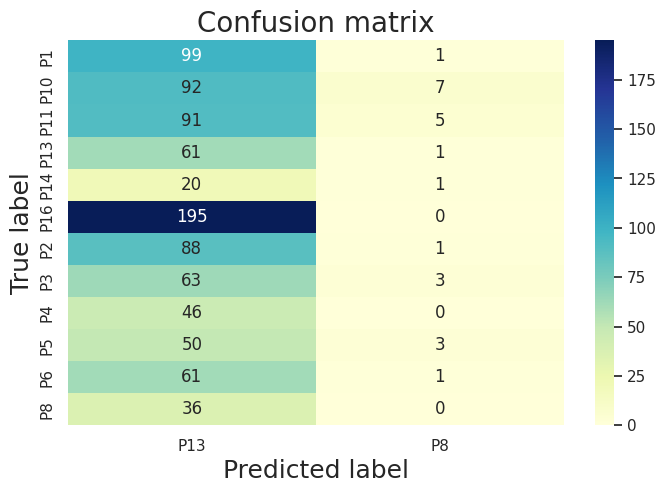

In [31]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

---------------------------------

### predict using Keras EfficientNetV2

In [5]:
import keras_efficientnet_v2

model = keras_efficientnet_v2.EfficientNetV2S(pretrained="imagenet")

# Run prediction
import tensorflow as tf
from tensorflow import keras
from skimage.data import chelsea

imm = tf.image.resize(chelsea(), model.input_shape[1:3]) # Chelsea the cat
pred = model(tf.expand_dims(imm / 128. - 1., 0)).numpy()
print(keras.applications.imagenet_utils.decode_predictions(pred)[0])

2022-09-30 15:07:00.900763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 15:07:01.306295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9454 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initaliz

87846816/87846816 [==============================] - 10s 0us/step
>>>> Load pretrained from: /home/kannika/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5


2022-09-30 15:07:15.401824: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-30 15:07:15.748386: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


35363/35363 [==============================] - 0s 1us/step
[('n02124075', 'Egyptian_cat', 0.86428815), ('n02123159', 'tiger_cat', 0.030793685), ('n02123045', 'tabby', 0.028082967), ('n02127052', 'lynx', 0.0020645922), ('n02125311', 'cougar', 0.0006871537)]


In [10]:
model

In [11]:
model.input_shape[1:3]

(384, 384)

In [6]:
0.86428815+0.030793685+0.028082967+0.0020645922+0.0006871537

0.9259165479000001

In [7]:
imm

<tf.Tensor: shape=(384, 384, 3), dtype=float32, numpy=
array([[[143.      , 120.      , 104.      ],
        [142.47656 , 119.47656 , 103.47656 ],
        [141.      , 118.      , 102.      ],
        ...,
        [ 47.18109 ,  27.436218,  13.872437],
        [ 45.      ,  27.      ,  13.      ],
        [ 45.      ,  27.      ,  13.      ]],

       [[144.95702 , 121.95701 , 105.95701 ],
        [143.82031 , 120.82031 , 104.82031 ],
        [142.05067 , 119.05068 , 103.05068 ],
        ...,
        [ 46.973713,  28.486885,  13.872437],
        [ 45.175842,  28.34375 ,  13.      ],
        [ 46.22651 ,  28.957005,  13.613255]],

       [[146.81902 , 124.27213 , 109.17838 ],
        [145.5014  , 122.71735 , 107.74219 ],
        [143.92317 , 120.470055, 105.82943 ],
        ...,
        [ 47.38336 ,  28.744537,  14.894291],
        [ 46.837036,  28.881409,  15.147034],
        [ 48.22441 ,  29.91275 ,  16.178375]],

       ...,

       [[112.7262  ,  77.63245 ,  47.444946],
        [126.

In [12]:
imm[0]

<tf.Tensor: shape=(384, 3), dtype=float32, numpy=
array([[143.      , 120.      , 104.      ],
       [142.47656 , 119.47656 , 103.47656 ],
       [141.      , 118.      , 102.      ],
       ...,
       [ 47.18109 ,  27.436218,  13.872437],
       [ 45.      ,  27.      ,  13.      ],
       [ 45.      ,  27.      ,  13.      ]], dtype=float32)>

In [8]:
type(imm)

tensorflow.python.framework.ops.EagerTensor

In [9]:
len(imm)

384

In [14]:
chelsea_data = chelsea()
print(len(chelsea_data))
type(chelsea_data)

300


numpy.ndarray

In [21]:
chelsea_data

array([[[143, 120, 104],
        [143, 120, 104],
        [141, 118, 102],
        ...,
        [ 45,  27,  13],
        [ 45,  27,  13],
        [ 45,  27,  13]],

       [[146, 123, 107],
        [145, 122, 106],
        [143, 120, 104],
        ...,
        [ 46,  29,  13],
        [ 45,  29,  13],
        [ 47,  30,  14]],

       [[148, 126, 112],
        [147, 125, 111],
        [146, 122, 109],
        ...,
        [ 48,  28,  17],
        [ 49,  29,  18],
        [ 50,  30,  19]],

       ...,

       [[ 92,  58,  30],
        [105,  71,  43],
        [132,  98,  71],
        ...,
        [172, 145, 138],
        [172, 145, 138],
        [172, 145, 138]],

       [[128,  92,  60],
        [139, 103,  71],
        [134,  95,  64],
        ...,
        [166, 142, 132],
        [166, 142, 132],
        [167, 143, 133]],

       [[139, 103,  71],
        [127,  88,  57],
        [125,  86,  53],
        ...,
        [161, 137, 127],
        [161, 137, 127],
        [162, 138, 128]]

In [16]:
TARGET_SIZE = (480, 480) 

In [19]:
import cv2
from tensorflow.keras.preprocessing import image

img_ = []
def convert_image(img_path):
    # Read the image and resize it
    img = cv2.imread(img_path)
    #img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    np.append(
    return x

array_imm_ = []
imm_ = []
img_path=valframe['path'].tolist()
for i in range(0,len(img_path)):
    array_imm = convert_image(img_path[i])
    array_imm_.append(array_imm)

In [33]:
img = cv2.imread(img_path[0])
print(type(img))
print(len((img)))
img

<class 'numpy.ndarray'>
295


array([[[191, 191, 191],
        [191, 191, 191],
        [192, 192, 192],
        ...,
        [184, 186, 187],
        [193, 195, 196],
        [183, 185, 186]],

       [[191, 191, 191],
        [191, 191, 191],
        [191, 191, 191],
        ...,
        [183, 185, 186],
        [191, 193, 194],
        [187, 189, 190]],

       [[193, 193, 193],
        [192, 192, 192],
        [191, 191, 191],
        ...,
        [181, 183, 184],
        [187, 189, 190],
        [183, 185, 186]],

       ...,

       [[183, 182, 178],
        [182, 181, 177],
        [181, 180, 176],
        ...,
        [115, 116, 114],
        [118, 119, 117],
        [113, 113, 113]],

       [[187, 186, 182],
        [185, 184, 180],
        [183, 182, 178],
        ...,
        [107, 108, 106],
        [112, 113, 111],
        [119, 119, 119]],

       [[194, 193, 189],
        [191, 190, 186],
        [188, 187, 183],
        ...,
        [104, 105, 103],
        [114, 115, 113],
        [126, 126, 126]]

In [39]:
#model = keras_efficientnet_v2.EfficientNetV2M(pretrained="imagenet")
mmodel = keras.models.load_model('/media/tohn/SSD/ModelEfficientV2/Model_effnetV2M_5ClassOV/efficientnetV2M_5ClassOV.h5')
#mmodel

imm = tf.image.resize(img, mmodel.input_shape[1:3])
pred = mmodel(tf.expand_dims(imm / 128. - 1., 0)).numpy()
print(keras.applications.imagenet_utils.decode_predictions(pred)[0])

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 6)

In [42]:
len(pred.shape)

2

In [38]:
pred

array([[0.05939584, 0.05751969, 0.05826009, 0.3949598 , 0.24864766,
        0.18121698]], dtype=float32)

In [40]:
(pred)[0]

array([0.05939584, 0.05751969, 0.05826009, 0.3949598 , 0.24864766,
       0.18121698], dtype=float32)

In [ ]:
0.363957

In [ ]:
imm = tf.image.resize(chelsea(), model.input_shape[1:3]) # Chelsea the cat
pred = model(tf.expand_dims(imm / 128. - 1., 0)).numpy()
print(keras.applications.imagenet_utils.decode_predictions(pred)[0])

In [24]:
img_ = []
for i in range(0,len(img_path)):
    # Read the image and resize it
    img = cv2.imread(img_path[i])
    #img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    img_.append(img)

In [25]:
print(len(array_imm_))
print(type(array_imm_))
array_imm_

300
<class 'list'>


[array([[[191., 191., 191.],
         [191., 191., 191.],
         [192., 192., 192.],
         ...,
         [184., 186., 187.],
         [193., 195., 196.],
         [183., 185., 186.]],
 
        [[191., 191., 191.],
         [191., 191., 191.],
         [191., 191., 191.],
         ...,
         [183., 185., 186.],
         [191., 193., 194.],
         [187., 189., 190.]],
 
        [[193., 193., 193.],
         [192., 192., 192.],
         [191., 191., 191.],
         ...,
         [181., 183., 184.],
         [187., 189., 190.],
         [183., 185., 186.]],
 
        ...,
 
        [[183., 182., 178.],
         [182., 181., 177.],
         [181., 180., 176.],
         ...,
         [115., 116., 114.],
         [118., 119., 117.],
         [113., 113., 113.]],
 
        [[187., 186., 182.],
         [185., 184., 180.],
         [183., 182., 178.],
         ...,
         [107., 108., 106.],
         [112., 113., 111.],
         [119., 119., 119.]],
 
        [[194., 193., 189.],
 

In [26]:
x_array = np.asarray(array_imm_)

/tmp/ipykernel_18497/2060971752.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_array = np.asarray(array_imm_)


In [27]:
print(len(x_array))
print(type(x_array))
x_array

300
<class 'numpy.ndarray'>


array([array([[[191., 191., 191.],
               [191., 191., 191.],
               [192., 192., 192.],
               ...,
               [184., 186., 187.],
               [193., 195., 196.],
               [183., 185., 186.]],

              [[191., 191., 191.],
               [191., 191., 191.],
               [191., 191., 191.],
               ...,
               [183., 185., 186.],
               [191., 193., 194.],
               [187., 189., 190.]],

              [[193., 193., 193.],
               [192., 192., 192.],
               [191., 191., 191.],
               ...,
               [181., 183., 184.],
               [187., 189., 190.],
               [183., 185., 186.]],

              ...,

              [[183., 182., 178.],
               [182., 181., 177.],
               [181., 180., 176.],
               ...,
               [115., 116., 114.],
               [118., 119., 117.],
               [113., 113., 113.]],

              [[187., 186., 182.],
               [1

In [20]:
print(len(array_imm_))
print(type(array_imm_))
array_imm_

300
<class 'list'>


[array([[[191., 191., 191.],
         [191., 191., 191.],
         [192., 192., 192.],
         ...,
         [184., 186., 187.],
         [193., 195., 196.],
         [183., 185., 186.]],
 
        [[191., 191., 191.],
         [191., 191., 191.],
         [191., 191., 191.],
         ...,
         [183., 185., 186.],
         [191., 193., 194.],
         [187., 189., 190.]],
 
        [[193., 193., 193.],
         [192., 192., 192.],
         [191., 191., 191.],
         ...,
         [181., 183., 184.],
         [187., 189., 190.],
         [183., 185., 186.]],
 
        ...,
 
        [[183., 182., 178.],
         [182., 181., 177.],
         [181., 180., 176.],
         ...,
         [115., 116., 114.],
         [118., 119., 117.],
         [113., 113., 113.]],
 
        [[187., 186., 182.],
         [185., 184., 180.],
         [183., 182., 178.],
         ...,
         [107., 108., 106.],
         [112., 113., 111.],
         [119., 119., 119.]],
 
        [[194., 193., 189.],
 